Previously, I implemented the bayesian version of the OC4 empirical chlorophyll algorithm, where the input consists in the log of the ratio of the maximum of three blue bands to a green band.
Here I will focus on the OC4 algorithm, part of the OCx family of empirical algorithms, which are  generally expressed as follows.
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$



In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from scipy.stats import norm
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
import pathlib
from sklearn.metrics import mean_squared_error, r2_score
from theano import shared
from matplotlib.pyplot import rcParams
from cmocean.cm import balance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [4]:
rc_ = {}
rc_['xtick.labelsize'] = 14
rc_['ytick.labelsize'] = 14
rc_['axes.formatter.limits'] = (-2, 3)
rc_['axes.labelsize'] = 14
rc_['font.size'] = 14
rc_['figure.titlesize'] = 20
rc_['axes.titlesize'] = 18

sb.set_style(style='darkgrid', rc=rc_)
sb.set_context(context='paper', rc=rc_)

In [5]:
%matplotlib inline

Define algorithms:

In [6]:
def rmse(y_true, y_pred, linear=False):
    if linear:
        y_true = np.power(10, y_true)
        y_pred = np.power(10, y_pred)
    return np.sqrt(mean_squared_error(y_true, y_pred))


def FitPoly(X, y, order=4, lin=False):
    """
    Numpy regression. Returns coeffs.
    kwargs:
        lin: specifies whether data is log transformed. Data is log transformed if not.
    """
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs



In [7]:
home = pathlib.Path.home()
root = home / 'DEV-ALL/Bayesian_Chl_Algorithms/pickleJar/'
dfNomadV2 = pd.read_pickle(os.path.join(root, 'dfNOMADV2.pkl'))

In [8]:
dfNomadV2.head()

id  depth    rrs411    rrs443    rrs489    rrs510    rrs555    rrs670  \
0  1565    0.0  0.001204  0.001686  0.003293  0.004036  0.007479  0.003465   
1  1566    0.0  0.001062  0.001384  0.002173  0.002499  0.004152  0.001695   
2  1567    1.0  0.000971  0.001185  0.001843  0.002288  0.004246  0.001612   
3  1568    3.0  0.001472  0.001741  0.002877  0.003664  0.006982  0.003234   
4  1559    1.0  0.000905  0.001022  0.001506  0.001903  0.002801  0.001791   

   hplc_chl  fluo_chl    sst      lat    lon            datetime  chl_all  
0       NaN     38.19   3.70  38.4279 -76.61 2003-04-15 15:15:00    38.19  
1       NaN     35.01   3.70  38.3680 -76.50 2003-04-15 16:50:00    35.01  
2       NaN     26.91   3.70  38.3074 -76.44 2003-04-15 17:50:00    26.91  
3       NaN     47.96   3.70  38.6367 -76.32 2003-04-17 18:15:00    47.96  
4       NaN     23.55  22.03  38.3047 -76.44 2003-07-21 18:27:00    23.55

In [9]:
dfNomadV2['hplc'] = dfNomadV2.fluo_chl.isnull()

In [10]:
dfNomadV2.drop(['hplc_chl', 'fluo_chl'], axis=1, inplace=True)

In [11]:
coli = [i for i in range(12)]
coli.extend([13, 12])

In [12]:
dfNomadV2 = dfNomadV2.iloc[:, coli]

In [13]:
dfNomadV2.head()

id  depth    rrs411    rrs443    rrs489    rrs510    rrs555    rrs670  \
0  1565    0.0  0.001204  0.001686  0.003293  0.004036  0.007479  0.003465   
1  1566    0.0  0.001062  0.001384  0.002173  0.002499  0.004152  0.001695   
2  1567    1.0  0.000971  0.001185  0.001843  0.002288  0.004246  0.001612   
3  1568    3.0  0.001472  0.001741  0.002877  0.003664  0.006982  0.003234   
4  1559    1.0  0.000905  0.001022  0.001506  0.001903  0.002801  0.001791   

     sst      lat    lon            datetime   hplc  chl_all  
0   3.70  38.4279 -76.61 2003-04-15 15:15:00  False    38.19  
1   3.70  38.3680 -76.50 2003-04-15 16:50:00  False    35.01  
2   3.70  38.3074 -76.44 2003-04-15 17:50:00  False    26.91  
3   3.70  38.6367 -76.32 2003-04-17 18:15:00  False    47.96  
4  22.03  38.3047 -76.44 2003-07-21 18:27:00  False    23.55

In [14]:
dfNomadV2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 14 columns):
id          1016 non-null int32
depth       1016 non-null float64
rrs411      1016 non-null float64
rrs443      1016 non-null float64
rrs489      1016 non-null float64
rrs510      1016 non-null float64
rrs555      1016 non-null float64
rrs670      1016 non-null float64
sst         1016 non-null float64
lat         1016 non-null float64
lon         1016 non-null float64
datetime    1016 non-null datetime64[ns]
hplc        1016 non-null bool
chl_all     1016 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(11), int32(1)
memory usage: 108.1 KB


In [15]:
dfNomadV2.describe()

id        depth       rrs411       rrs443       rrs489  \
count  1016.000000  1016.000000  1016.000000  1016.000000  1016.000000   
mean   4598.373031   661.871063     0.004701     0.004743     0.005511   
std    2318.827769  1462.690737     0.003984     0.003586     0.004028   
min    1441.000000     0.000000     0.000051     0.000190     0.000367   
25%    2118.750000     8.000000     0.002000     0.002338     0.003063   
50%    3702.500000    25.000000     0.003400     0.003800     0.004695   
75%    7036.250000   171.500000     0.006500     0.006200     0.006400   
max    7831.000000  5707.000000     0.030600     0.027601     0.030200   

            rrs510       rrs555       rrs670          sst          lat  \
count  1016.000000  1016.000000  1016.000000  1016.000000  1016.000000   
mean      0.005304     0.005418     0.001571    21.635069    27.051691   
std       0.004294     0.005260     0.002387     7.187604    18.331380   
min       0.000497     0.000417     0.000036     0.880000   -62.441000   
25%       0.002900     0.001886     0.000200    16.310000    26.395850   
50%       0.003800     0.003262     0.000614    23.940000    29.663800   
75%       0.006100     0.007201     0.002000    27.660000    37.626850   
max       0.032900     0.046600     0.027700    30.890000    44.015000   

               lon      chl_all  
count  1016.000000  1016.000000  
mean    -78.132377     4.042444  
std      38.558797     7.736291  
min    -179.955000     0.017000  
25%     -88.211125     0.349475  
50%     -82.549500     1.169500  
75%     -70.771200     3.752000  
max     178.867000    77.864800

In [16]:
dfcorr = dfNomadV2.drop(['id','hplc'], axis=1).corr()

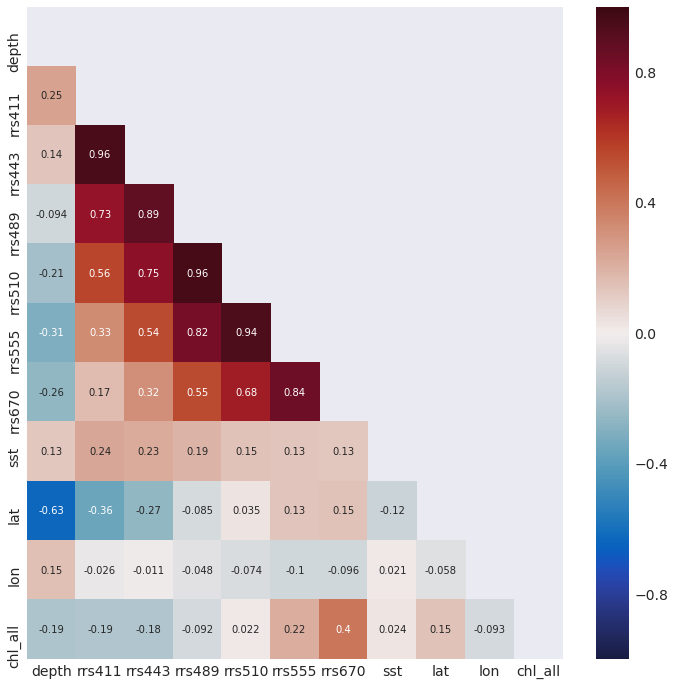

In [17]:
f, ax = pl.subplots(figsize=(12,12))
sb.heatmap(dfcorr, ax=ax, annot=True, mask=np.triu(np.ones(dfcorr.shape)), cmap=balance, vmin=-1, vmax=1)

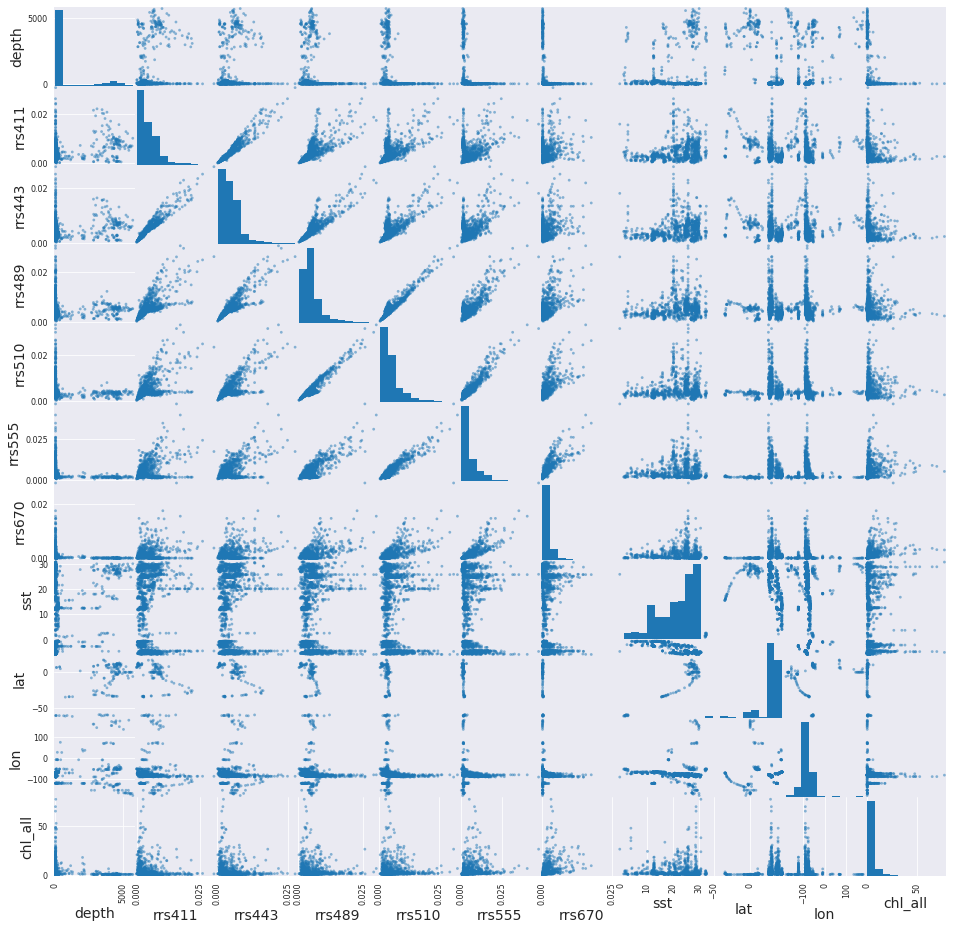

In [18]:
pd.plotting.scatter_matrix(dfNomadV2.drop(['id', 'hplc'], axis=1), figsize=(16, 16));

In [44]:
dfNomadV2['maxBlue'] = dfNomadV2.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1)
dfNomadV2['blue2green'] = dfNomadV2.maxBlue / dfNomadV2.rrs555
dfLogOC4 = pd.DataFrame(columns=['id','mxBl2Gr', 'chl',])
dfLogOC4['id'] = dfNomadV2.id
dfLogOC4['mxBlId'] = dfNomadV2.loc[:, ['rrs443', 'rrs489', 'rrs510']].idxmax(axis=1)
dfLogOC4['mxBl2Gr'] = np.log10(dfNomadV2.blue2green.values)
dfLogOC4['chl'] = np.log10(dfNomadV2.chl_all.values)

In [45]:
dfLogOC4.head()

id   mxBl2Gr       chl  mxBlId
0  1565 -0.267867  1.581950  rrs510
1  1566 -0.220457  1.544192  rrs510
2  1567 -0.268537  1.429914  rrs510
3  1568 -0.279976  1.680879  rrs510
4  1559 -0.167733  1.371991  rrs510

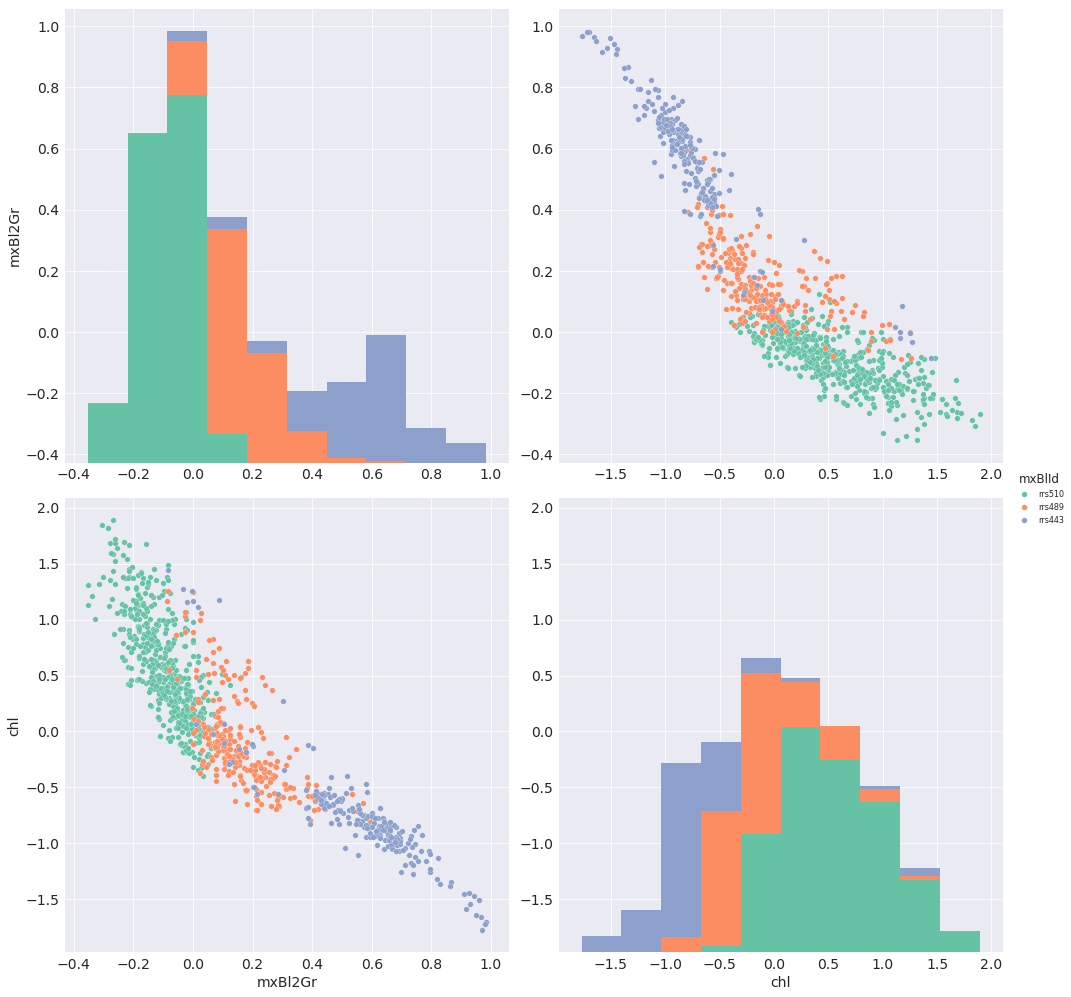

In [48]:
sb.pairplot(dfLogOC4.drop('id', axis=1), size=7, hue='mxBlId', palette="Set2")

In [57]:
dfLogOC4.loc[dfLogOC4.mxBlId=='rrs443', :].describe().loc['min']

id         1595.000000
mxBl2Gr      -0.084664
chl          -1.769551
Name: min, dtype: float64

In [54]:
dfLogOC4.loc[dfLogOC4.mxBlId=='rrs489', :].describe()

id     mxBl2Gr         chl
count   272.000000  272.000000  272.000000
mean   4795.746324    0.161094   -0.122917
std    2410.243873    0.116536    0.414425
min    1607.000000   -0.087009   -0.812197
25%    2115.500000    0.078870   -0.403560
50%    4844.500000    0.143781   -0.196203
75%    7091.500000    0.228231    0.041901
max    7831.000000    0.595889    1.257487

In [104]:
dfLog = dfNomadV2[['rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs555', 'rrs670', 'chl_all']]
dfLog = np.log10(dfLog)
ins =dfLog.shape[1]-2
dfLog.insert(0, 'log_depth', np.log10(dfNomadV2.depth+1e-6))
dfLog.insert(ins, 'sst', dfNomadV2.sst)
dfLog.insert(ins, 'depth', dfNomadV2.depth)
dfLog.insert(0, 'lat', dfNomadV2.lat)
dfLog.insert(0, 'lon', dfNomadV2.lon)
dfLog.insert(0, 'datetime', dfNomadV2.datetime)
dfLog.insert(1, 'month', dfNomadV2.datetime.dt.month)
dfLog.insert(2, 'hour', dfLog.datetime.dt.hour)
dfLog.insert(0, 'ID', dfNomadV2.id)
dfLog.insert(ins, 'hplc', dfNomadV2.hplc)
dfLog.insert(ins, 'maxBlue', dfLog.loc[:, ['rrs443', 'rrs489', 'rrs510']].max(axis=1))
dfLog.insert(ins, 'maxBluId', dfLog.loc[:, ['rrs443', 'rrs489', 'rrs510']].idxmax(axis=1))
dfLog.insert(ins, 'mxBluGr', dfLog.loc[:, ['rrs443', 'rrs489', 'rrs510', 'rrs555']].max(axis=1))
dfLog.insert(ins, 'mxBluGrId', dfLog.loc[:, ['rrs443', 'rrs489', 'rrs510', 'rrs555']].idxmax(axis=1))
dfLog.insert(ins, 'mxBluAllGrId', dfLog.loc[:, ['rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs555']].idxmax(axis=1))
dfLog.insert(ins, 'mxAllId', dfLog.filter(regex='rrs').idxmax(axis=1))
dfLog.insert(ins, 'mxBlu2Gr', dfLog.maxBlue / dfLog.rrs555)
dfLog.insert(ins, 'Red2Gr', dfLog.rrs670 / dfLog.rrs555)
dfLog.insert(ins, 'Bl2Rd', dfLog.rrs411 / dfLog.rrs670)
dfLog.insert(ins, 'Rd2Bl', dfLog.rrs670 / dfLog.rrs411)
dfLog.insert(ins, 'RedxGr', np.sqrt(dfLog.rrs670 * dfLog.rrs555))
dfLog.insert(ins, 'mxBlu2Rd', dfLog.maxBlue / dfLog.rrs670)
dfLog.insert(ins, 'Rd2MxBlu', dfLog.rrs670 / dfLog.maxBlue)
dfLog.insert(ins, 'mxBluGr2Rd', dfLog.mxBluGr / dfLog.rrs670)
dfLog.rename(columns={'chl_all': 'chlor_a'}, inplace=True)
dfLog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 31 columns):
ID              1016 non-null int32
datetime        1016 non-null datetime64[ns]
month           1016 non-null int64
hour            1016 non-null int64
lon             1016 non-null float64
mxBluGr2Rd      1016 non-null float64
Rd2MxBlu        1016 non-null float64
mxBlu2Rd        1016 non-null float64
RedxGr          1016 non-null float64
Rd2Bl           1016 non-null float64
Bl2Rd           1016 non-null float64
Red2Gr          1016 non-null float64
mxBlu2Gr        1016 non-null float64
mxAllId         1016 non-null object
mxBluAllGrId    1016 non-null object
mxBluGrId       1016 non-null object
mxBluGr         1016 non-null float64
maxBluId        1016 non-null object
maxBlue         1016 non-null float64
hplc            1016 non-null bool
lat             1016 non-null float64
log_depth       1016 non-null float64
rrs411          1016 non-null float64
rrs443          1016 non-

In [105]:
dfLog.head().T

0                    1                    2  \
ID                           1565                 1566                 1567   
datetime      2003-04-15 15:15:00  2003-04-15 16:50:00  2003-04-15 17:50:00   
month                           4                    4                    4   
hour                           15                   16                   17   
lon                        -76.61                -76.5               -76.44   
mxBluGr2Rd               0.864163             0.859564             0.849421   
Rd2MxBlu                  1.02771              1.06482              1.05755   
mxBlu2Rd                 0.973036             0.939127             0.945583   
RedxGr                    2.28715              2.56894              2.57374   
Rd2Bl                    0.842809             0.931697             0.926923   
Bl2Rd                     1.18651              1.07331              1.07884   
Red2Gr                    1.15719              1.16338              1.17727   
mxBlu2Gr                  1.12599              1.09256              1.11321   
mxAllId                    rrs555               rrs555               rrs555   
mxBluAllGrId               rrs555               rrs555               rrs555   
mxBluGrId                  rrs555               rrs555               rrs555   
mxBluGr                  -2.12615             -2.38173             -2.37206   
maxBluId                   rrs510               rrs510               rrs510   
maxBlue                  -2.39401             -2.60219              -2.6406   
hplc                        False                False                False   
lat                       38.4279               38.368              38.3074   
log_depth                      -6                   -6          4.34294e-07   
rrs411                   -2.91923               -2.974             -3.01272   
rrs443                   -2.77312             -2.85886              -2.9261   
rrs489                    -2.4824             -2.66296             -2.73443   
rrs510                   -2.39401             -2.60219              -2.6406   
depth                           0                    0                    1   
sst                           3.7                  3.7                  3.7   
rrs555                   -2.12615             -2.38173             -2.37206   
rrs670                   -2.46035             -2.77086             -2.79256   
chlor_a                   1.58195              1.54419              1.42991   

                                3                    4  
ID                           1568                 1559  
datetime      2003-04-17 18:15:00  2003-07-21 18:27:00  
month                           4                    7  
hour                           18                   18  
lon                        -76.32               -76.44  
mxBluGr2Rd               0.865781             0.929274  
Rd2MxBlu                  1.02228              1.00976  
mxBlu2Rd                 0.978208             0.990334  
RedxGr                    2.31714               2.6481  
Rd2Bl                     0.87929             0.902643  
Bl2Rd                     1.13728              1.10786  
Red2Gr                    1.15503              1.07611  
mxBlu2Gr                  1.12986              1.06571  
mxAllId                    rrs555               rrs555  
mxBluAllGrId               rrs555               rrs555  
mxBluGrId                  rrs555               rrs555  
mxBluGr                  -2.15604             -2.55274  
maxBluId                   rrs510               rrs510  
maxBlue                  -2.43601             -2.72047  
hplc                        False                False  
lat                       38.6367              38.3047  
log_depth                0.477121          4.34294e-07  
rrs411                   -2.83215             -3.04331  
rrs443                   -2.75914             -2.99041  
rrs489                   -2.54101              -2.8222  
rrs510               

In [23]:
dfLog.describe()

ID        month         hour          lon          lat  \
count  1016.000000  1016.000000  1016.000000  1016.000000  1016.000000   
mean   4598.373031     6.545276    16.712598   -78.132377    27.051691   
std    2318.827769     2.883949     3.461268    38.558797    18.331380   
min    1441.000000     1.000000     0.000000  -179.955000   -62.441000   
25%    2118.750000     4.000000    15.000000   -88.211125    26.395850   
50%    3702.500000     7.000000    17.000000   -82.549500    29.663800   
75%    7036.250000     9.000000    19.000000   -70.771200    37.626850   
max    7831.000000    12.000000    23.000000   178.867000    44.015000   

             depth       rrs411       rrs443       rrs489       rrs510  \
count  1016.000000  1016.000000  1016.000000  1016.000000  1016.000000   
mean      1.238016    -2.469966    -2.434733    -2.348028    -2.372404   
std       2.072415     0.372152     0.322377     0.277348     0.276308   
min      -6.000000    -4.290672    -3.721171    -3.435402    -3.303393   
25%       0.903090    -2.698900    -2.631142    -2.513907    -2.537605   
50%       1.397940    -2.468523    -2.420232    -2.328363    -2.420169   
75%       2.234259    -2.187091    -2.207596    -2.193829    -2.214667   
max       3.756408    -1.514280    -1.559082    -1.519995    -1.482807   

          ...            rrs670          sst      maxBlue      mxBluGr  \
count     ...       1016.000000  1016.000000  1016.000000  1016.000000   
mean      ...         -3.175779    21.635069    -2.301973    -2.251127   
std       ...          0.588881     7.187604     0.282739     0.282558   
min       ...         -4.440321     0.880000    -3.303393    -3.194182   
25%       ...         -3.698398    16.310000    -2.493597    -2.450818   
50%       ...         -3.212071    23.940000    -2.284004    -2.244109   
75%       ...         -2.699023    27.660000    -2.125559    -2.086145   
max       ...         -1.557521    30.890000    -1.482807    -1.331613   

          mxBlu2Gr       Red2Gr       RedxGr     mxBlu2Rd   mxBluGr2Rd  \
count  1016.000000  1016.000000  1016.000000  1016.000000  1016.000000   
mean      0.961589     1.308600     2.769447     0.745073     0.725422   
std       0.108796     0.111132     0.447479     0.134802     0.113430   
min       0.645498     0.981690     1.440144     0.435350     0.435350   
25%       0.900559     1.223276     2.413035     0.645600     0.645600   
50%       0.991380     1.312229     2.818530     0.747896     0.743736   
75%       1.041777     1.390511     3.146867     0.847187     0.811139   
max       1.152717     1.714152     3.857423     1.074909     1.018652   

           chlor_a  
count  1016.000000  
mean      0.089204  
std       0.702093  
min      -1.769551  
25%      -0.456596  
50%       0.068000  
75%       0.574263  
max       1.891341  

[8 rows x 21 columns]

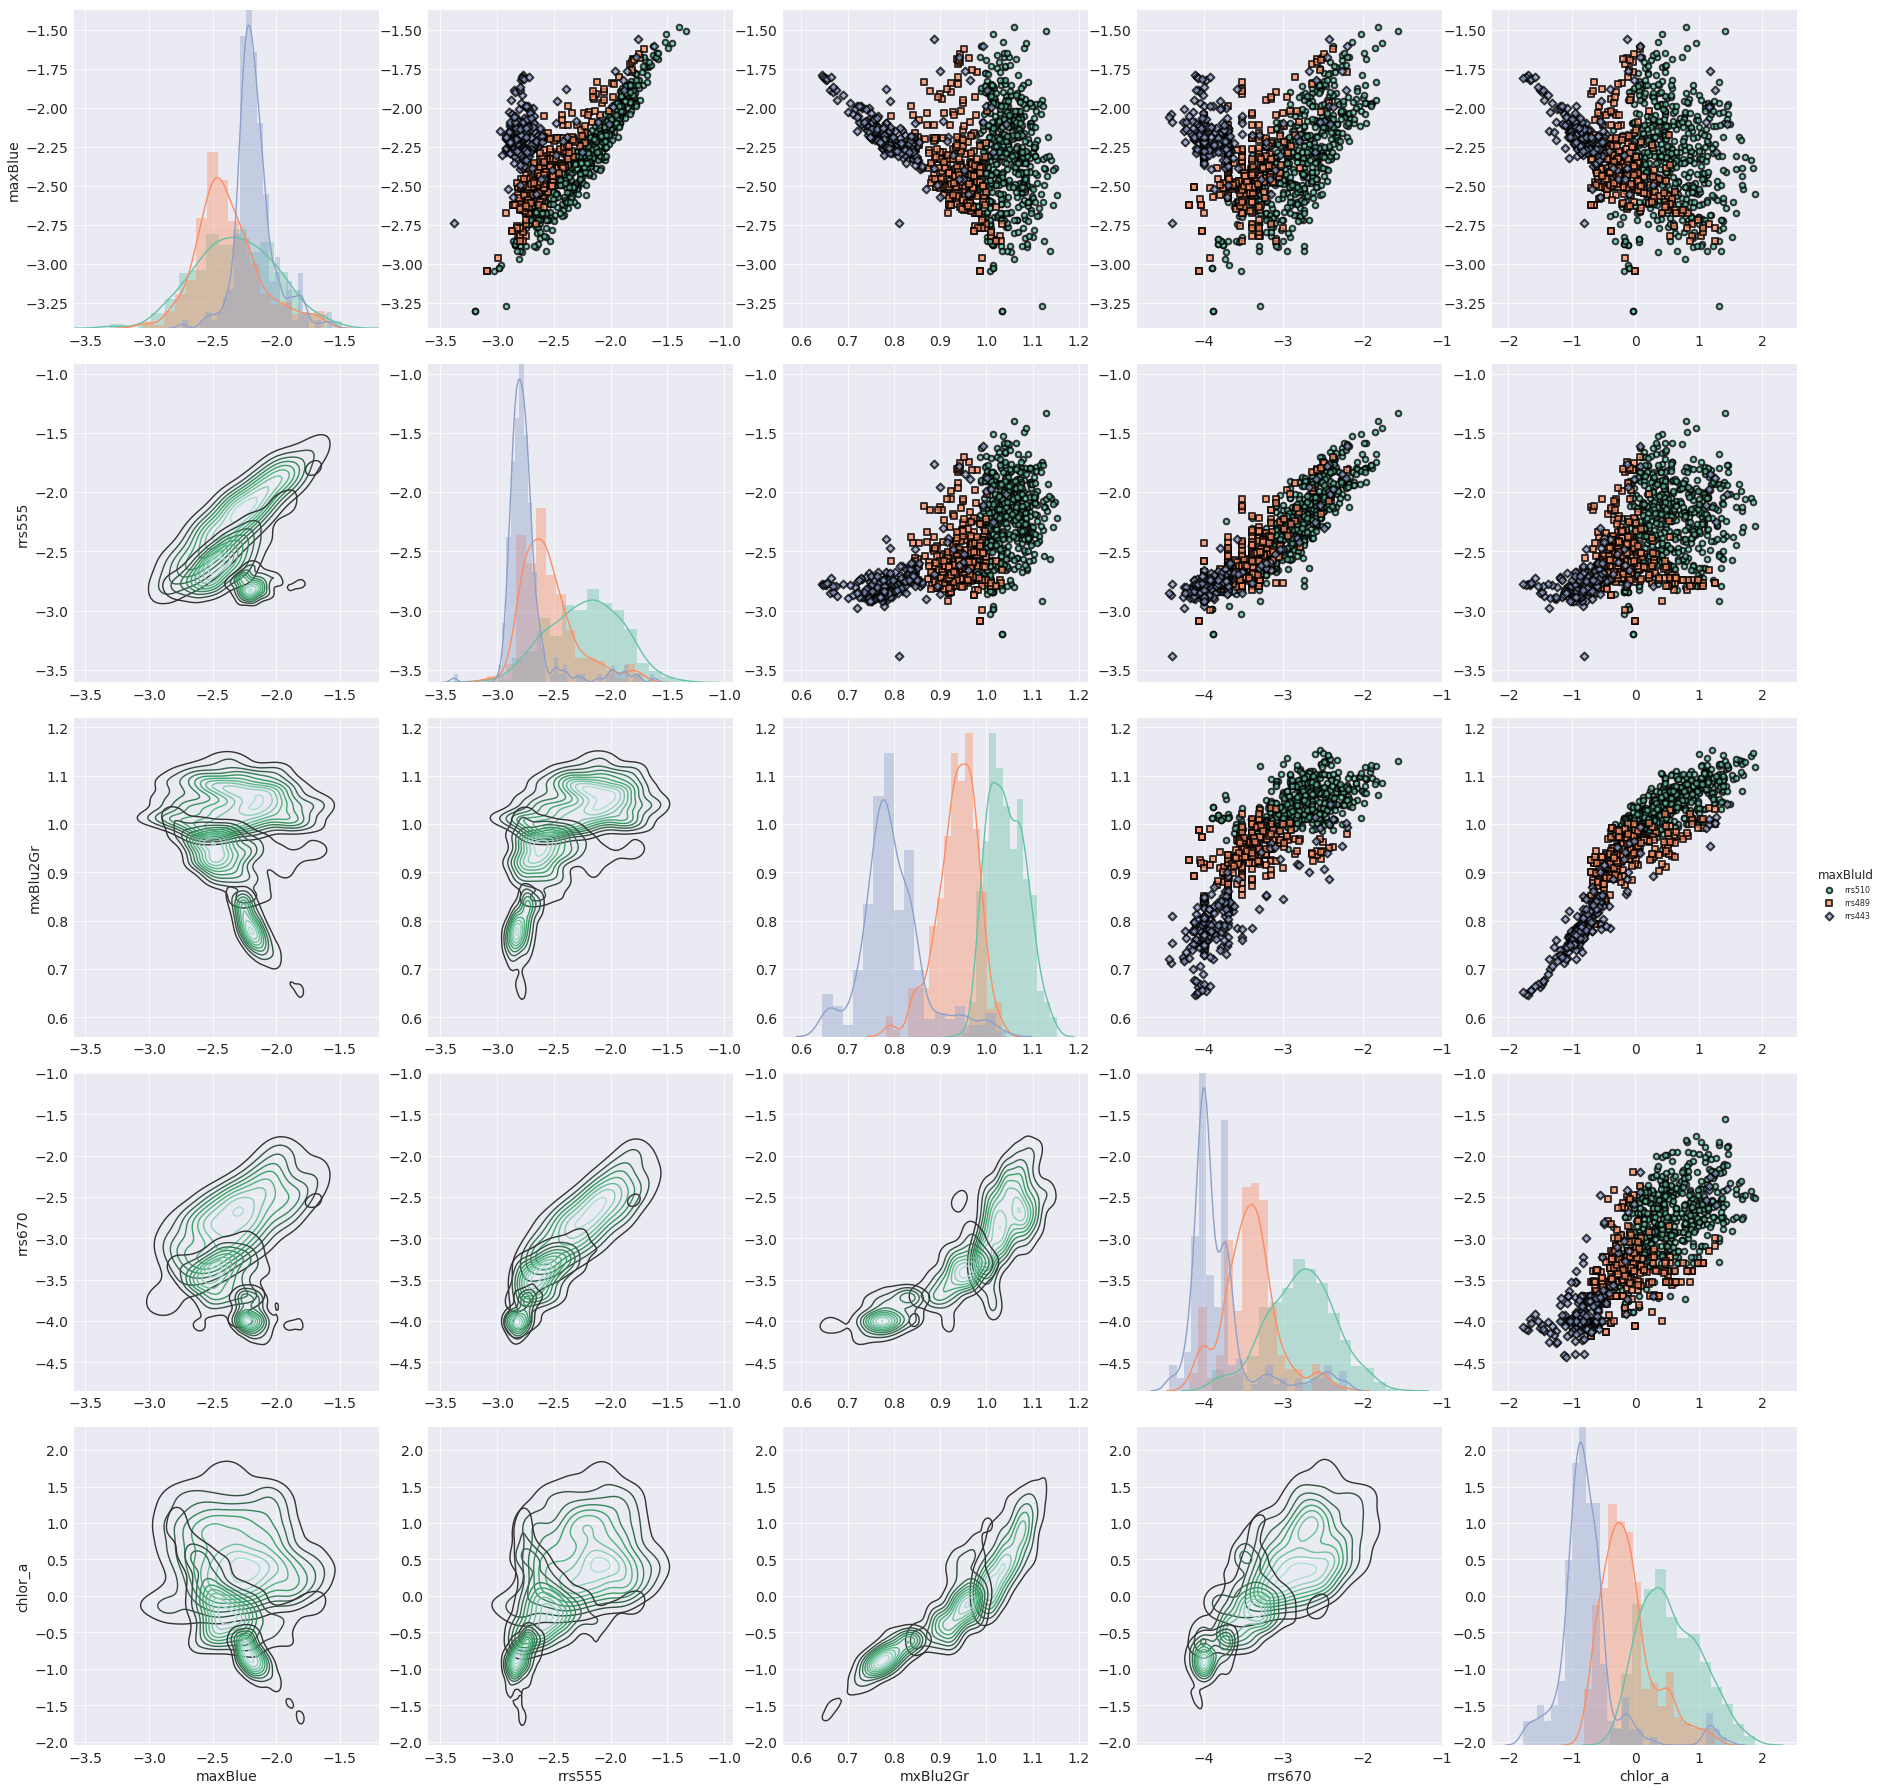

In [24]:
g = sb.PairGrid(dfLog, vars=['maxBlue', 'rrs555', 'mxBlu2Gr','rrs670', 'chlor_a'], size=5, diag_sharey=False, 
                hue='maxBluId', palette="Set2",
                hue_kws={"marker": ["o", "s", "D"]});
g = g.map_diag(sb.distplot, norm_hist=True)#, lw=3)
g = g.map_lower(sb.kdeplot)
g = g.map_upper(pl.scatter ,alpha=0.75, edgecolor='k', linewidth=2)
g.add_legend();

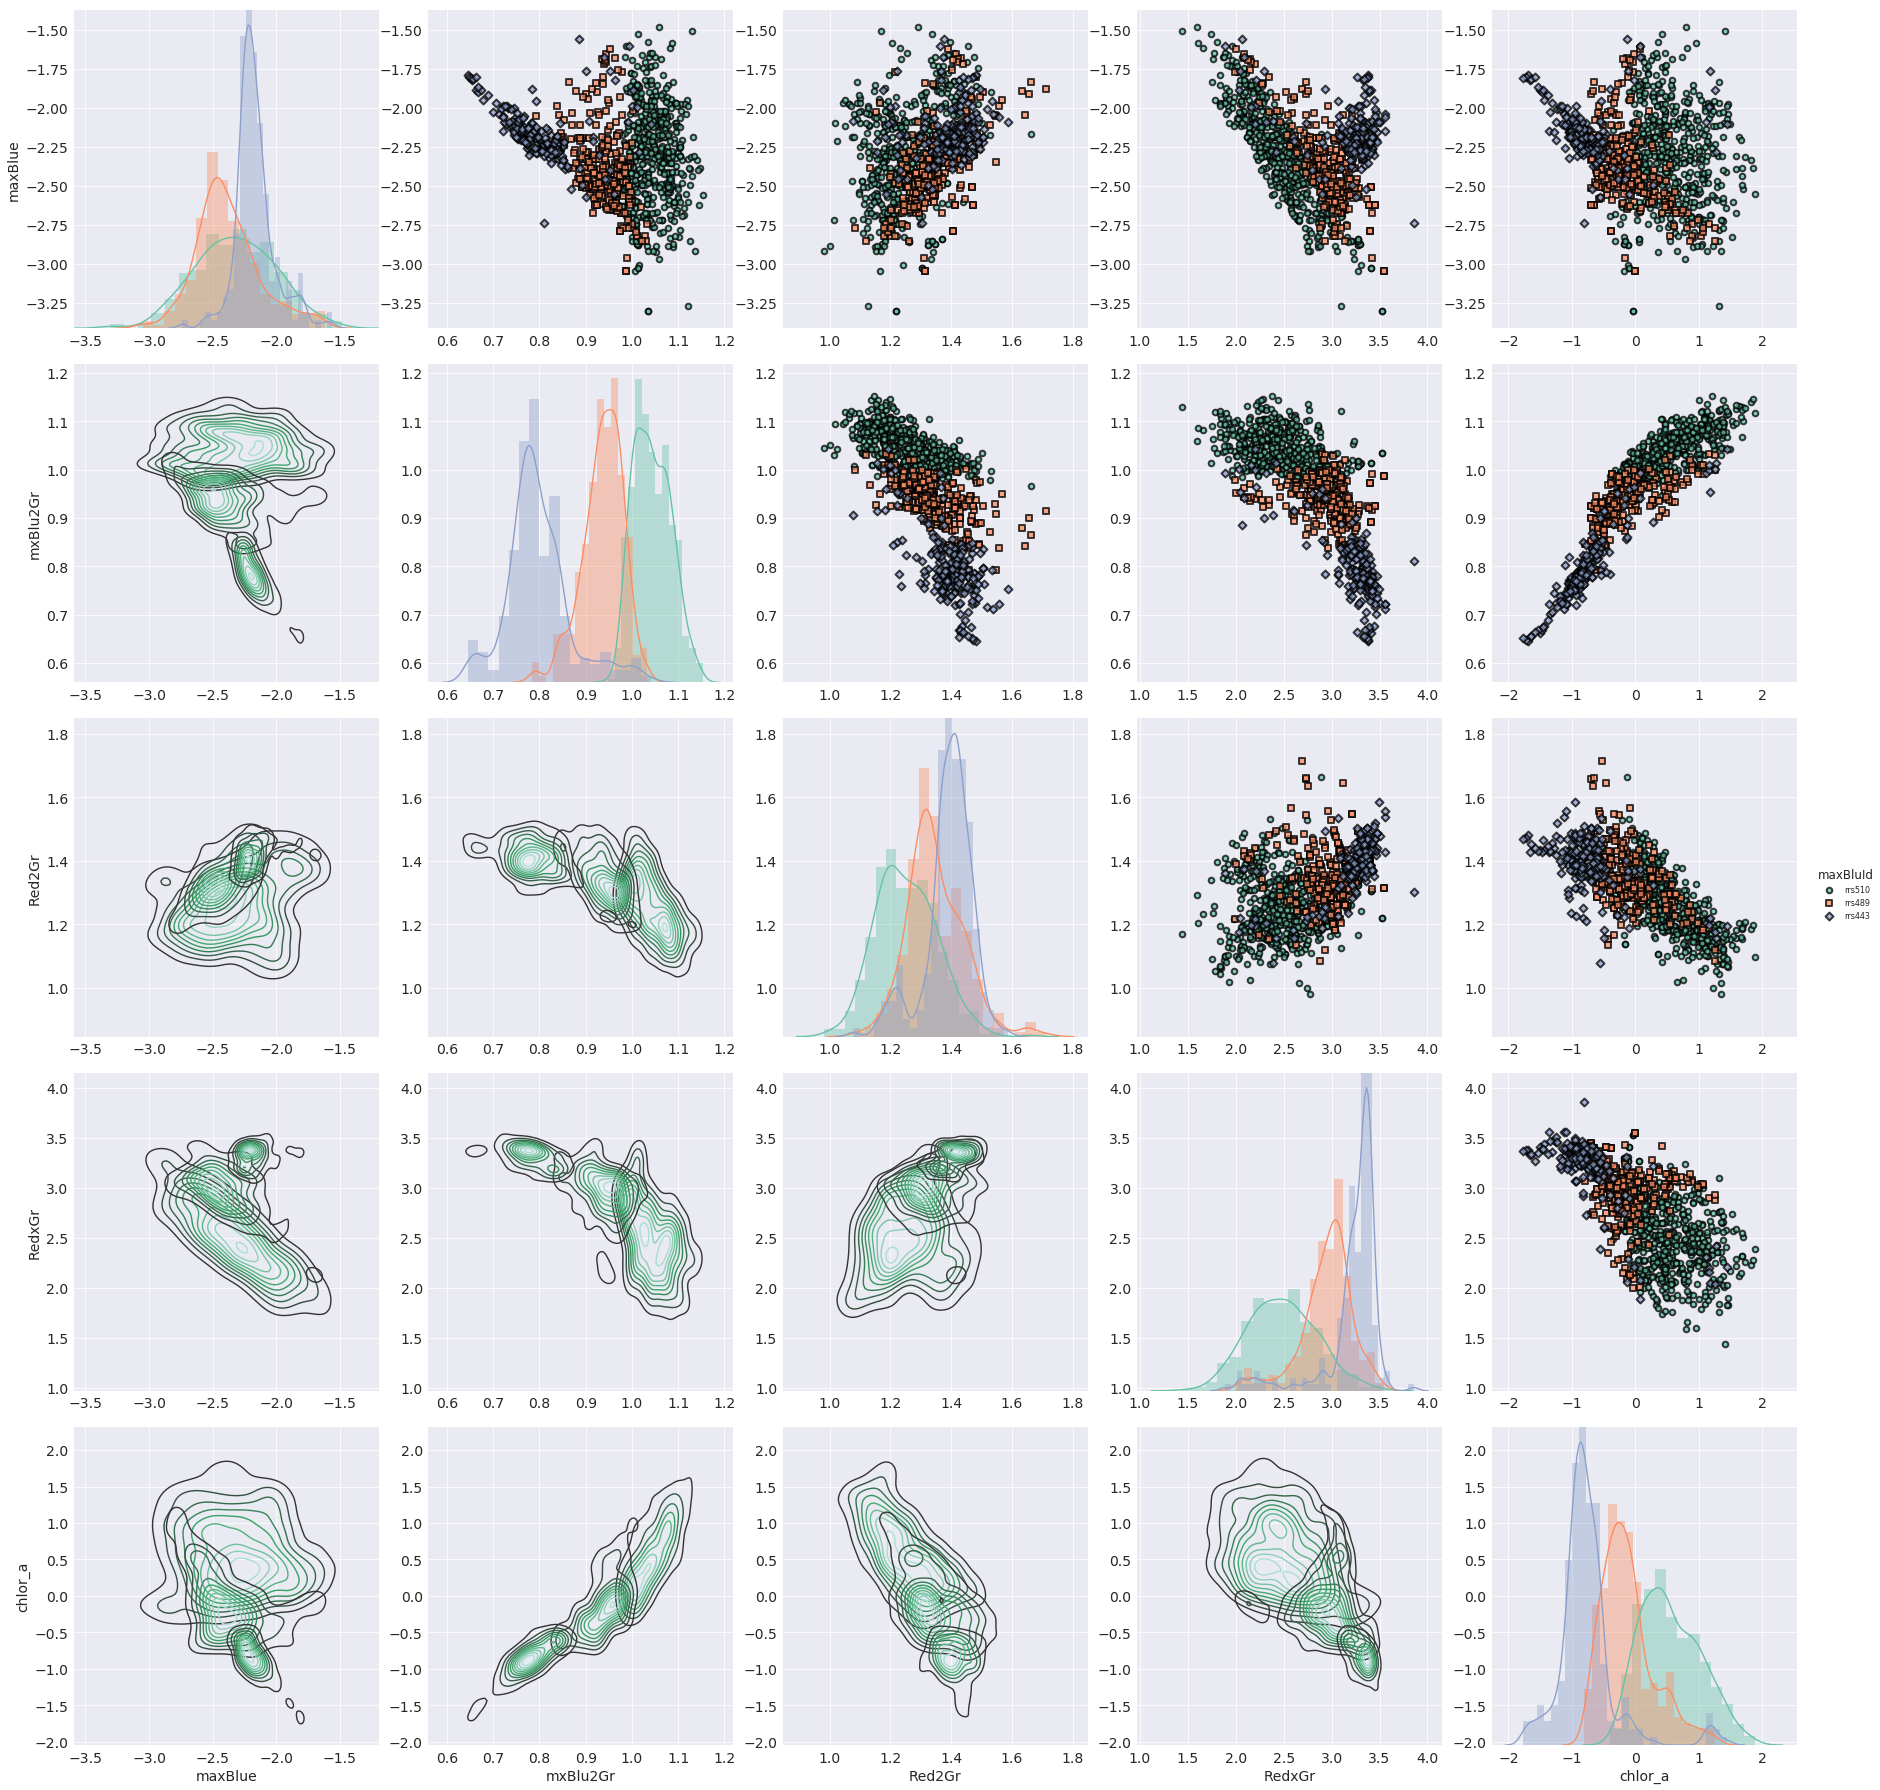

In [25]:
#g = sb.PairGrid(dfLog, vars=['maxBlue', 'rrs555', 'mxBlu2Gr','rrs670', 'chlor_a'], size=5, diag_sharey=False,
g = sb.PairGrid(dfLog, vars=['maxBlue', 'mxBlu2Gr', 'Red2Gr', 'RedxGr', 'chlor_a'], size=5, diag_sharey=False,
                hue='maxBluId', palette="Set2",
                hue_kws={"marker": ["o", "s", "D"]});
g = g.map_diag(sb.distplot, norm_hist=True)#, lw=3)
g = g.map_lower(sb.kdeplot)
g = g.map_upper(pl.scatter ,alpha=0.75, edgecolor='k', linewidth=2)
g.add_legend();

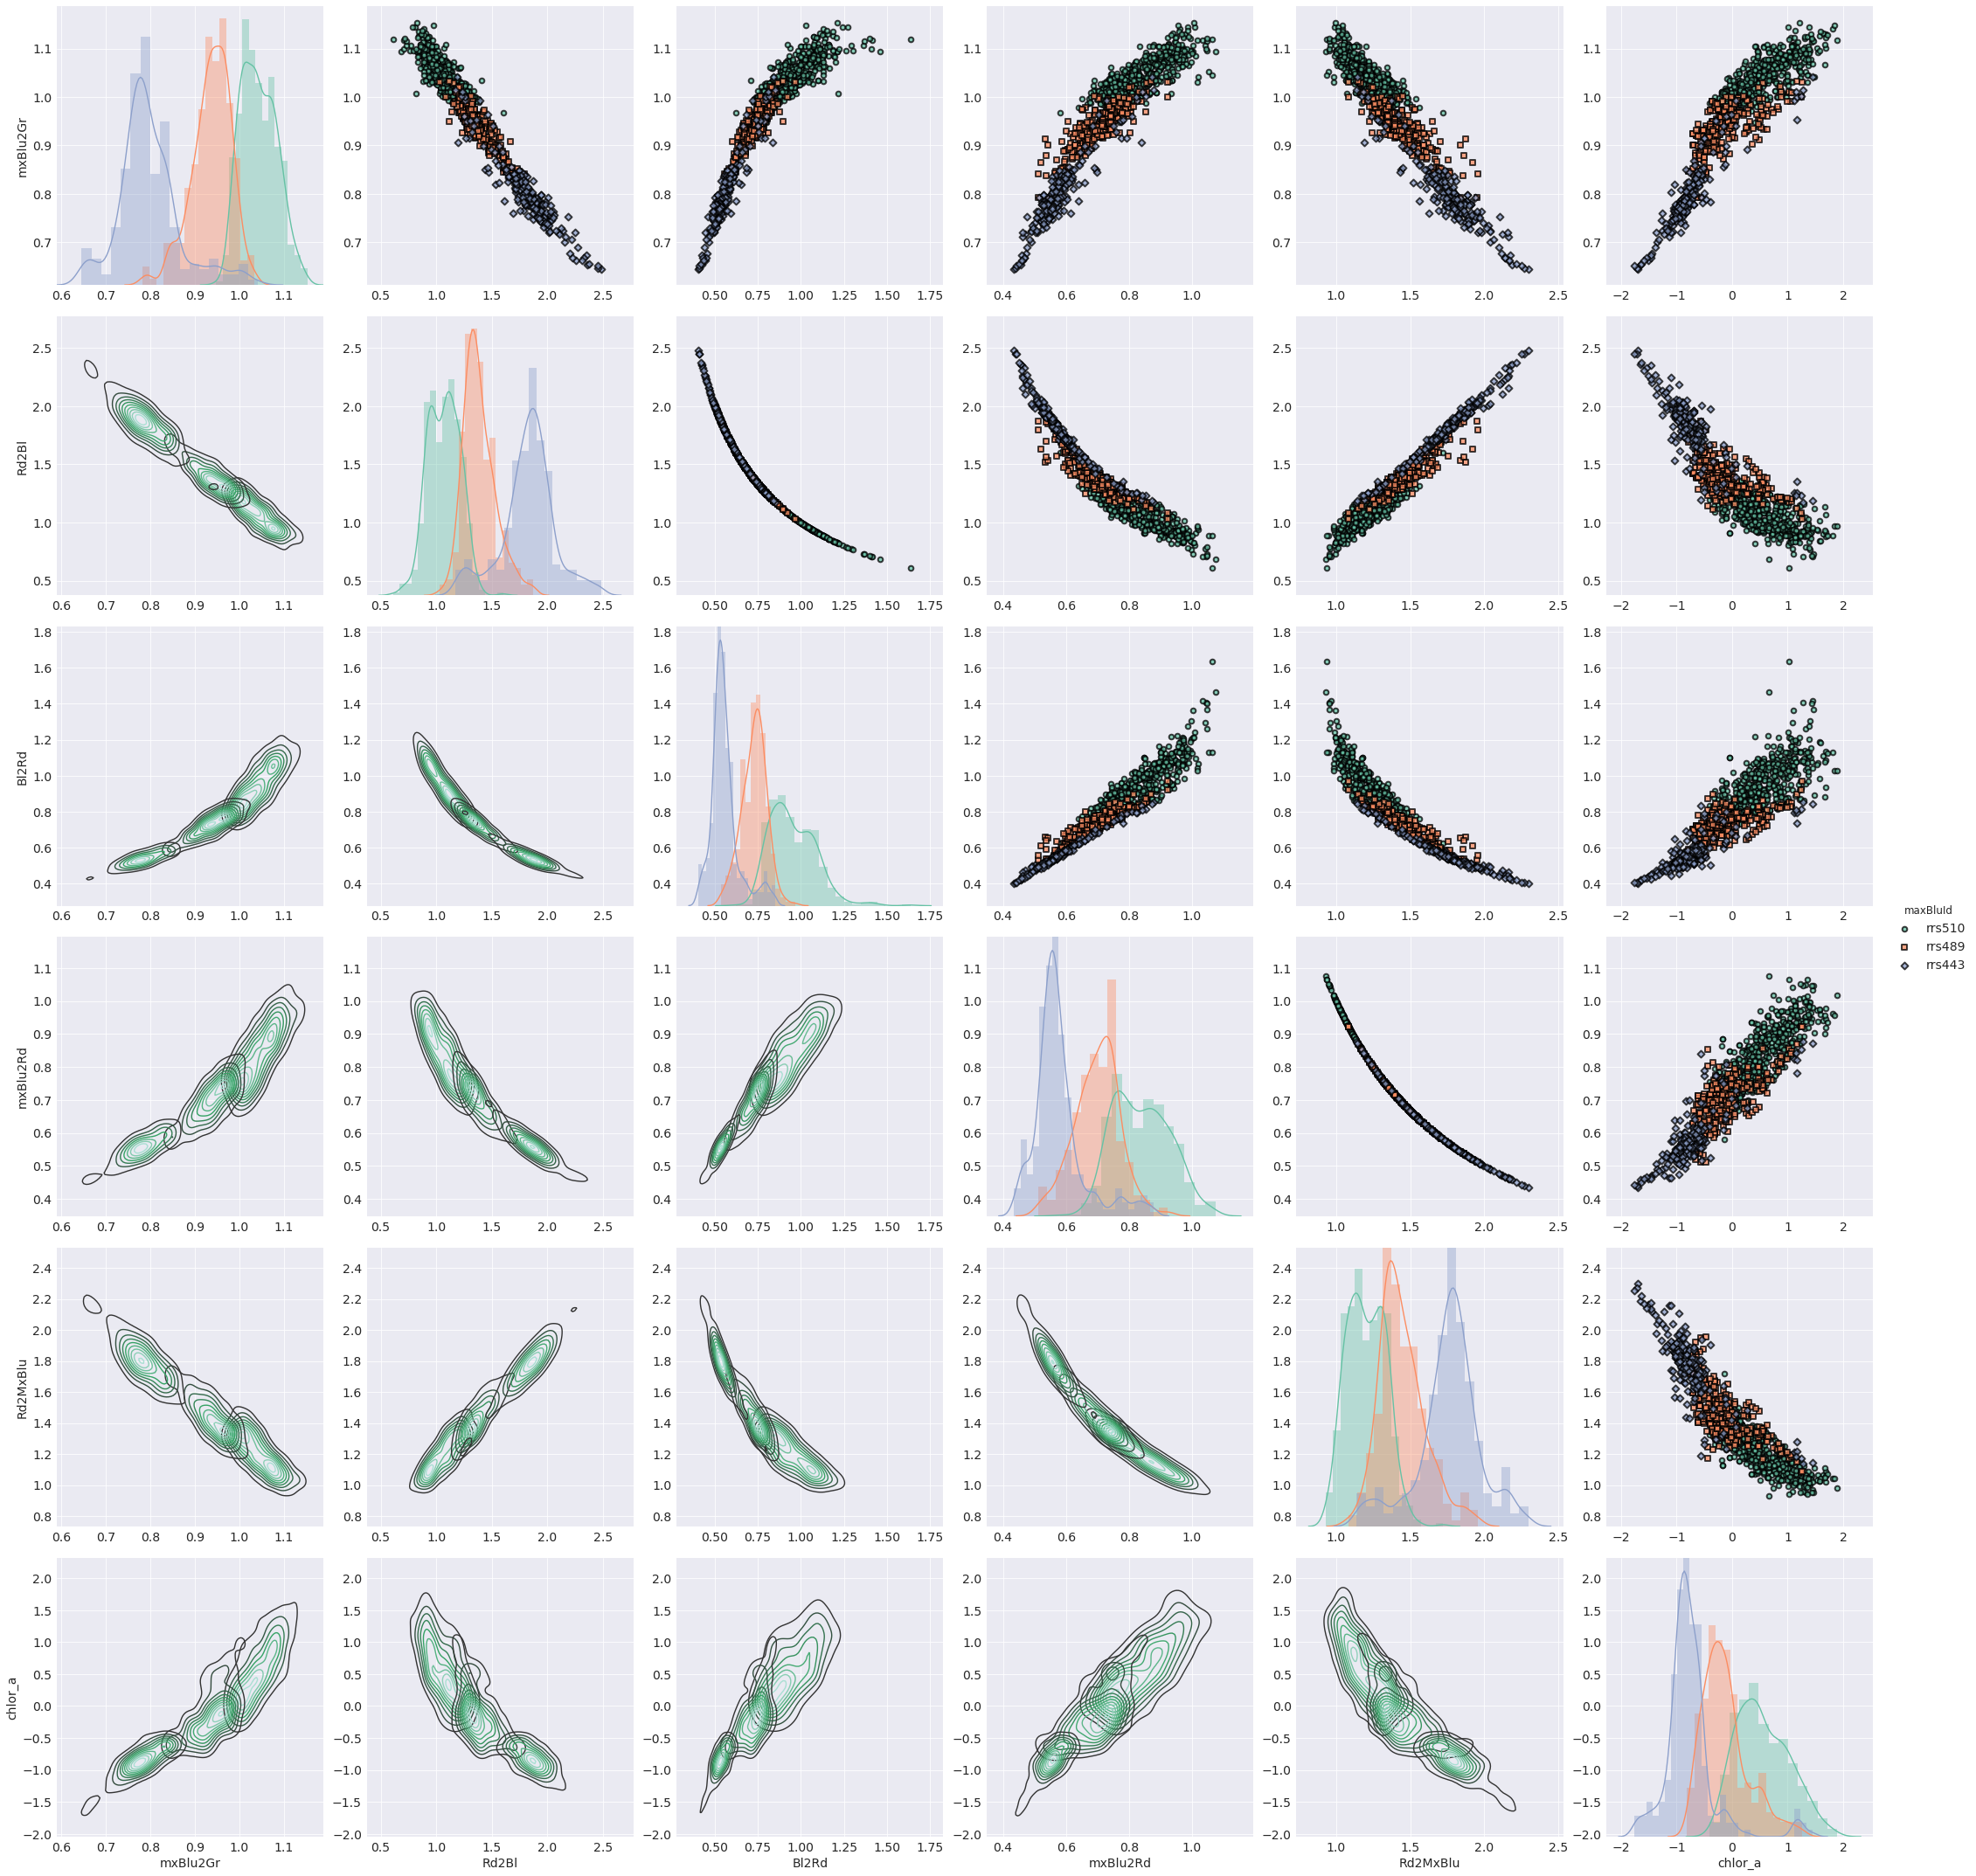

In [86]:
#g = sb.PairGrid(dfLog, vars=['maxBlue', 'rrs555', 'mxBlu2Gr','rrs670', 'chlor_a'], size=5, diag_sharey=False,
sb.set_style(rc=rc_)
g = sb.PairGrid(dfLog, vars=['mxBlu2Gr', 'Rd2Bl', 'Bl2Rd', 'mxBlu2Rd', 'Rd2MxBlu', 'chlor_a'], size=5, diag_sharey=False,
                hue='maxBluId', palette="Set2",
                hue_kws={"marker": ["o", "s", "D"]});
g = g.map_diag(sb.distplot, norm_hist=True)#, lw=3)
g = g.map_lower(sb.kdeplot)
g = g.map_upper(pl.scatter ,alpha=0.75, edgecolor='k', linewidth=2)
g.add_legend(fontsize=14);

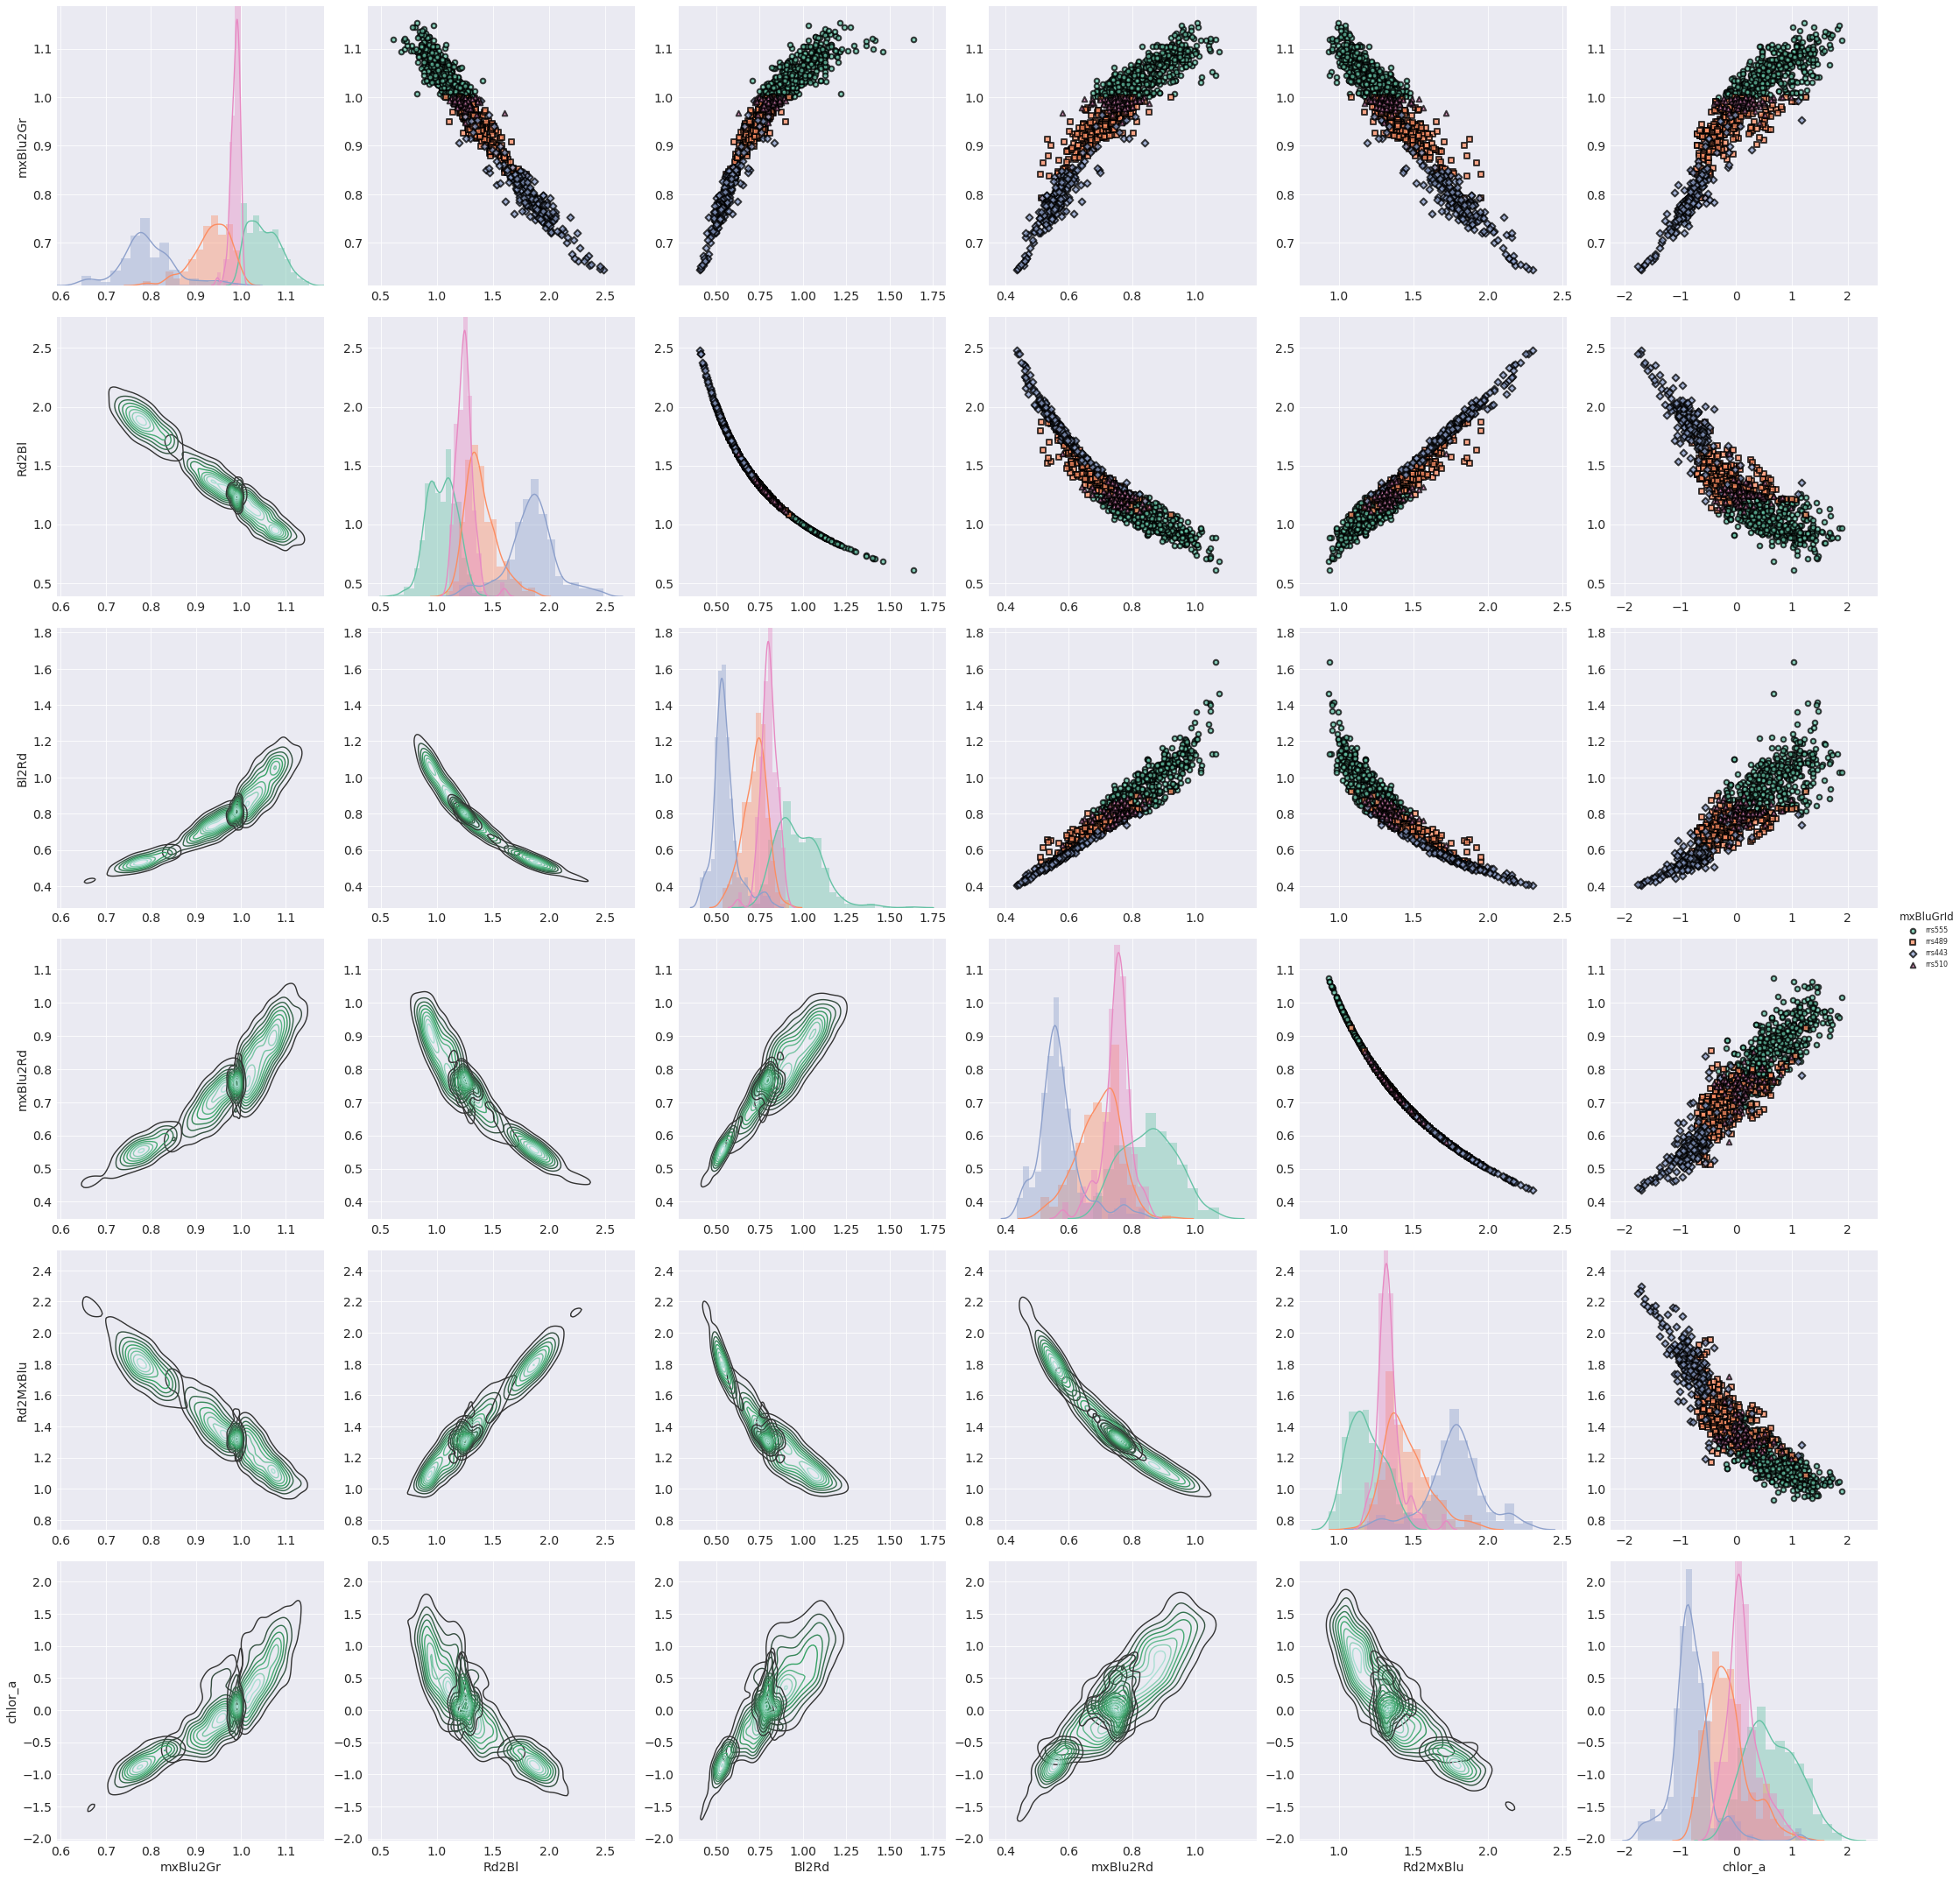

In [87]:
g = sb.PairGrid(dfLog, vars=['mxBlu2Gr', 'Rd2Bl', 'Bl2Rd', 'mxBlu2Rd', 'Rd2MxBlu', 'chlor_a'], size=5,
                diag_sharey=False, hue='mxBluGrId', palette="Set2",
                hue_kws={"marker": ["o", "s", "D", "^"]});
g = g.map_diag(sb.distplot, norm_hist=True)
g = g.map_lower(sb.kdeplot, lw=3)
g = g.map_upper(pl.scatter ,alpha=0.75, edgecolor='k', linewidth=2)
g.add_legend();

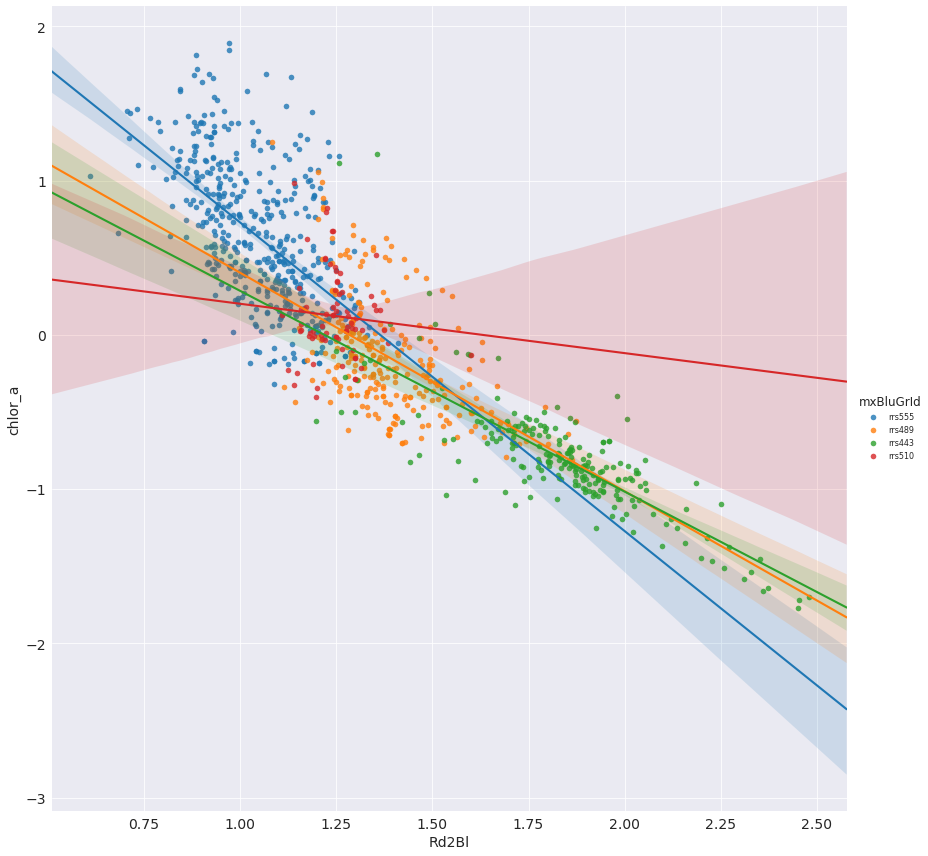

In [110]:
sb.lmplot(x='Rd2Bl', y='chlor_a', data=dfLog[['Rd2Bl', 'chlor_a', 'mxBluGrId']], hue='mxBluGrId', size=12)

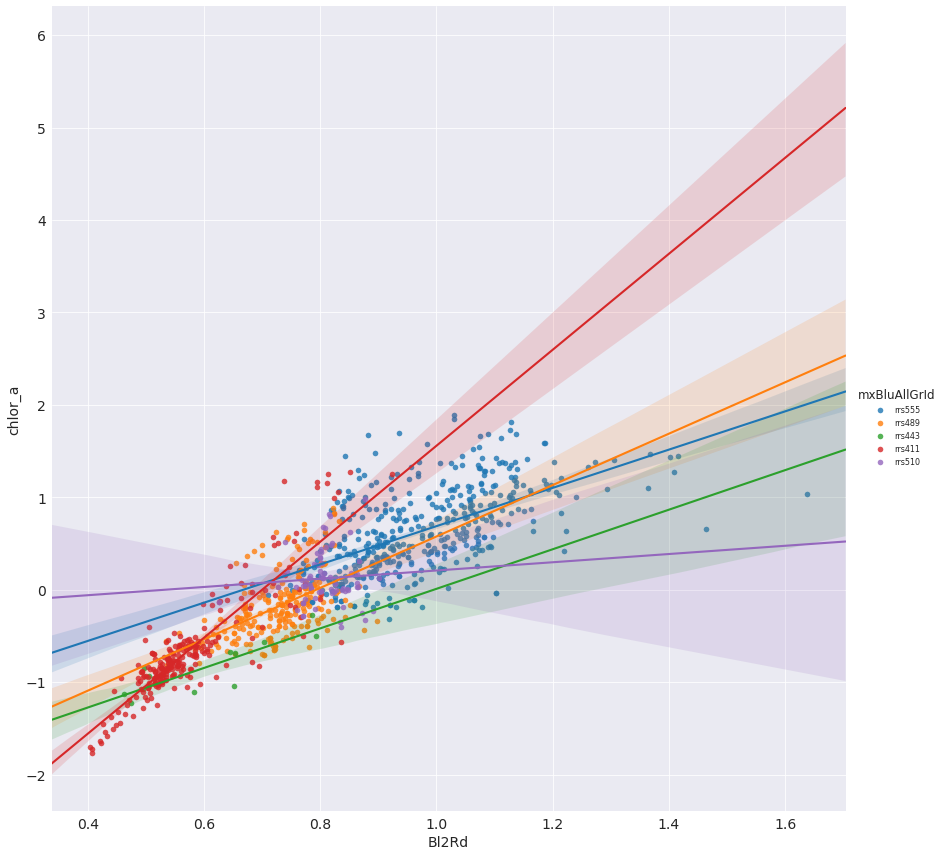

In [112]:
fg=sb.lmplot(x='Bl2Rd', y='chlor_a', data=dfLog[['Bl2Rd', 'chlor_a', 'mxBluAllGrId']], hue='mxBluAllGrId', size=12)

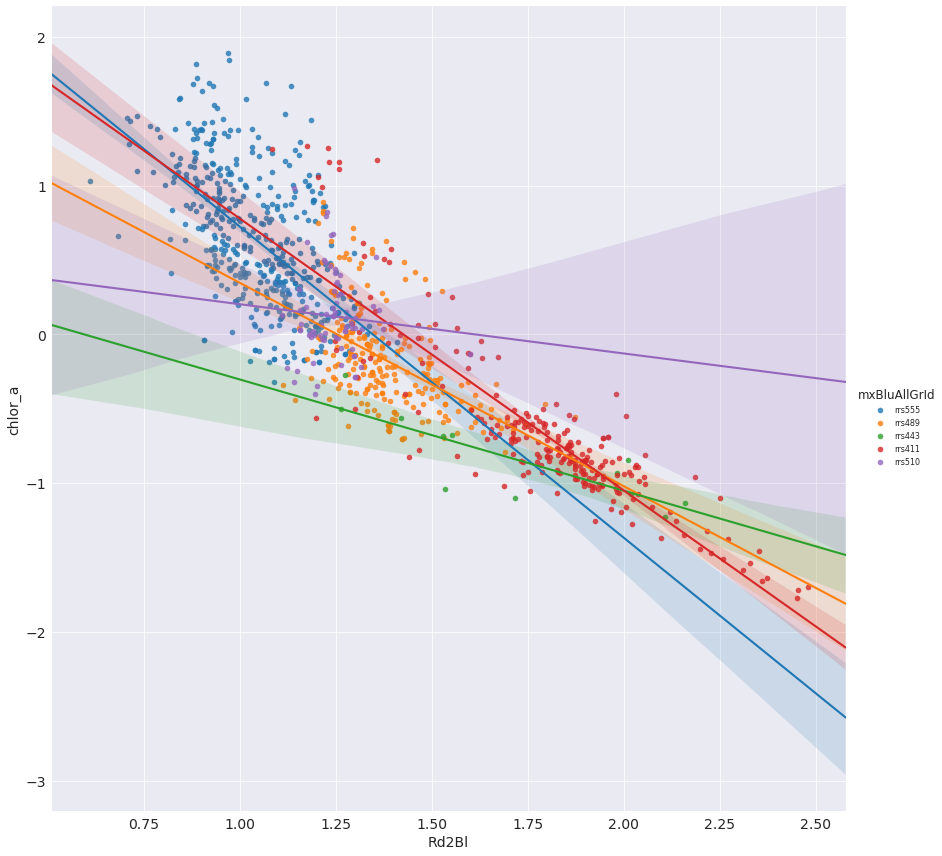

In [114]:
fg=sb.lmplot(x='Rd2Bl', y='chlor_a', data=dfLog[['Rd2Bl', 'chlor_a', 'mxBluAllGrId']],
             hue='mxBluAllGrId', size=12)

In [ ]:
dfLog['mxBl']

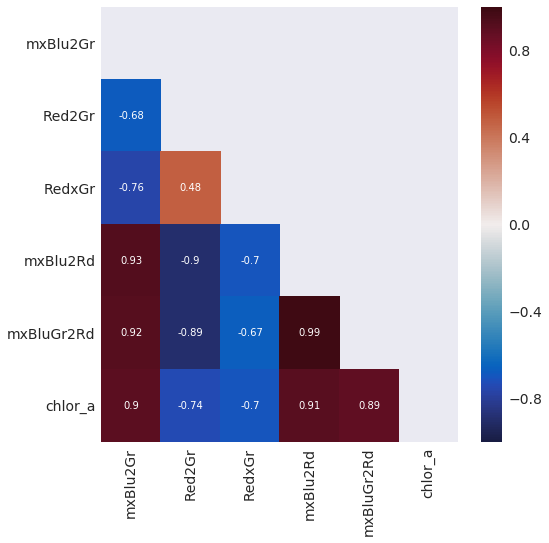

In [28]:
_, ax = pl.subplots(figsize=(8, 8))
sb.heatmap(dfLog[['mxBlu2Gr', 'Red2Gr', 'RedxGr', 'mxBlu2Rd', 'mxBluGr2Rd', 'chlor_a']].corr(), annot=True, 
           vmin=-1, vmax=1, cmap=balance, mask=np.triu(np.ones((6,6))), ax=ax);

In [29]:
y_true = dfLog.chlor_a.values.reshape(-1, 1)

In [30]:
lrBl2Rd = LinearRegression()
lrBl2Gr = LinearRegression()
lrBlGr2Rd = LinearRegression()
lr4 = LinearRegression()
lr5 = LinearRegression()
lr5p = LinearRegression()

In [59]:
dfLog.head().T

0                    1                    2  \
ID                         1565                 1566                 1567   
datetime    2003-04-15 15:15:00  2003-04-15 16:50:00  2003-04-15 17:50:00   
month                         4                    4                    4   
hour                         15                   16                   17   
lon                      -76.61                -76.5               -76.44   
lat                     38.4279               38.368              38.3074   
depth                        -6                   -6          4.34294e-07   
rrs411                 -2.91923               -2.974             -3.01272   
rrs443                 -2.77312             -2.85886              -2.9261   
rrs489                  -2.4824             -2.66296             -2.73443   
rrs510                 -2.39401             -2.60219              -2.6406   
rrs555                 -2.12615             -2.38173             -2.37206   
rrs670                 -2.46035             -2.77086             -2.79256   
sst                         3.7                  3.7                  3.7   
hplc                      False                False                False   
maxBlue                -2.39401             -2.60219              -2.6406   
maxBluId                 rrs510               rrs510               rrs510   
mxBluGr                -2.12615             -2.38173             -2.37206   
mxBluGrId                rrs555               rrs555               rrs555   
mxBlu2Gr                1.12599              1.09256              1.11321   
Red2Gr                  1.15719              1.16338              1.17727   
RedxGr                  2.28715              2.56894              2.57374   
mxBlu2Rd               0.973036             0.939127             0.945583   
mxBluGr2Rd             0.864163             0.859564             0.849421   
chlor_a                 1.58195              1.54419              1.42991   

                              3                    4  
ID                         1568                 1559  
datetime    2003-04-17 18:15:00  2003-07-21 18:27:00  
month                         4                    7  
hour                         18                   18  
lon                      -76.32               -76.44  
lat                     38.6367              38.3047  
depth                  0.477121          4.34294e-07  
rrs411                 -2.83215             -3.04331  
rrs443                 -2.75914             -2.99041  
rrs489                 -2.54101              -2.8222  
rrs510                 -2.43601             -2.72047  
rrs555                 -2.15604             -2.55274  
rrs670                 -2.49028             -2.74702  
sst                         3.7                22.03  
hplc                      False                False  
maxBlue                -2.43601             -2.72047  
maxBluId                 rrs510               rrs510  
mxBluGr                -2.15604             -2.55274  
mxBluGrId                rrs555               rrs555  
mxBlu2Gr                1.12986              1.06571  
Red2Gr                  1.15503              1.07611  
RedxGr                  2.31714               2.6481  
mxBlu2Rd               0.978208             0.990334  
mxBluGr2Rd             0.865781             0.929274  
chlor_a                 1.68088              1.37199

In [31]:
mxBlu2Rd = dfLog.mxBlu2Rd.values.reshape(-1, 1)
mxBlu2Gr = dfLog.mxBlu2Gr.values.reshape(-1, 1)
mxBluGr2Rd = dfLog.mxBluGr2Rd.values.reshape(-1, 1)
X4 = dfLog.as_matrix(columns=['mxBluGr2Rd', 'Red2Gr'])
X5 = dfLog.as_matrix(columns=['mxBlu2Rd', 'depth'])
X6 = dfLog.as_matrix(columns=['mxBlu2Rd', 'depth'])

In [32]:
polfit = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
ss5p = StandardScaler()
ss5 = StandardScaler()

In [33]:
X4p = polfit.fit_transform(X4)
X5p = polfit.fit_transform(X5)

In [34]:
X5_s = ss5.fit_transform(X5)
X5_ps = ss5p.fit_transform(X5p)

In [35]:
lrBl2Rd.fit(mxBlu2Rd, y_true)
lrBl2Gr.fit(mxBlu2Gr, y_true)
lrBlGr2Rd.fit(mxBluGr2Rd, y_true)
lr4.fit(X4p, y_true)
lr5.fit(X5_s, y_true)
lr5p.fit(X5_ps, y_true)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
yp_Bl2Rd = lrBl2Rd.predict(mxBlu2Rd)
yp_Bl2Gr = lrBl2Gr.predict(mxBlu2Gr)
yp_BG2Rd = lrBlGr2Rd.predict(mxBluGr2Rd)
yp_4 = lr4.predict(X4p)
yp_5 = lr5.predict(X5_s)
yp_5p = lr5p.predict(X5_ps)

In [37]:
OC4v6_coeffs = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]
mdlOC4v6 = np.poly1d(OC4v6_coeffs[::-1])
y_predOC4v6 = mdlOC4v6(dfLogOC4.mxBl2Gr)

genericOC4_Coefs = FitPoly(dfLogOC4.mxBl2Gr.values,dfLogOC4.chl,lin=False)
mdlFreq= np.poly1d(genericOC4_Coefs) # encapsulate the fit results into a polynomial object
y_pred_deg4 = mdlFreq(dfLogOC4.mxBl2Gr) # evaluate polynomial with input data

In [38]:
print(f'rmse_OC4v6: {rmse(y_true, y_predOC4v6)}')
print(f'rmse_Poly4: {rmse(y_true, y_pred_deg4)}')
print(f'rmse_Bl2Rd: {rmse(y_true, yp_Bl2Rd)}')
print(f'rmse_Bl2Gr: {rmse(y_true, yp_Bl2Gr)}')
print(f'rmse_BlGr2Rd: {rmse(y_true, yp_BG2Rd)}')
# includes mxBlGr2Rd and Rd2Gr
print(f'rmse_4: {rmse(y_true, yp_4)}')
# includes mxBl2Rd and depth
print(f'rmse_5: {rmse(y_true, yp_5)}')
print(f'rmse_5p: {rmse(y_true, yp_5p)}')

rmse_OC4v6: 0.2983330141337295
rmse_Poly4: 0.28999498196897117
rmse_Bl2Rd: 0.29150470434186126
rmse_Bl2Gr: 0.3068274557559042
rmse_BlGr2Rd: 0.32519070769861036
rmse_4: 0.3076550164931271
rmse_5: 0.2889262842870531
rmse_5p: 0.28884257150902604


In [39]:
# RMSE in LINEAR SPACE
print(f'rmse_OC4v6: {rmse(y_true, y_predOC4v6, linear=True)}')
print(f'rmse_Poly4: {rmse(y_true, y_pred_deg4, linear=True)}')
print(f'rmse_Bl2Rd: {rmse(y_true, yp_Bl2Rd, linear=True)}')
print(f'rmse_Bl2Gr: {rmse(y_true, yp_Bl2Gr, linear=True)}')
print(f'rmse_BlGr2Rd: {rmse(y_true, yp_BG2Rd, linear=True)}')
print(f'rmse_4: {rmse(y_true, yp_4, linear=True)}')
print(f'rmse_5: {rmse(y_true, yp_5, linear=True)}')
print(f'rmse_5p: {rmse(y_true, yp_5p, linear=True)}')

rmse_OC4v6: 5.859418720861938
rmse_Poly4: 5.952359228326117
rmse_Bl2Rd: 5.9290216088900785
rmse_Bl2Gr: 6.3671197790810705
rmse_BlGr2Rd: 6.6203130541082595
rmse_4: 7.265594582403789
rmse_5: 5.7190906274655555
rmse_5p: 5.736234755504618


Ideas: 
In a subsequent notebook, I will build a out-of-sample test data set to validate the performance of these algorithms.

In [71]:
df_test = pd.read_pickle('./pickleJar/dfSwfChloraMups2010p.pkl')

In [72]:
df_test.head()

id  latitude  longitude           date_time  \
0  280136   29.0527   -87.3232 2010-05-13 21:02:00   
1  279946   23.0139    59.9755 2010-03-10 11:37:00   
2  279960  -40.6083   -51.9662 2010-11-29 17:10:00   
3  293134   29.3085   -83.3641 2010-11-01 17:03:00   
4  279633   43.7335   -70.0121 2010-03-09 17:56:00   

                                              cruise  seawifs_solz  \
0  0           2010_05_wbii\n1        abudhabi-ma...         35.43   
1  0           2010_05_wbii\n1        abudhabi-ma...         40.02   
2  0           2010_05_wbii\n1        abudhabi-ma...         27.31   
3  0           2010_05_wbii\n1        abudhabi-ma...         54.43   
4  0           2010_05_wbii\n1        abudhabi-ma...         58.24   

   seawifs_senz  seawifs_windspeed  seawifs_tdiff  seawifs_mxBl2Gr  \
0         29.85              6.367          -2866         3.155524   
1         34.64              2.418          -5159         0.946126   
2         35.67              4.074          -1264         3.173533   
3         53.08              1.221           8852         0.700750   
4         23.68              3.795           4861         0.904325   

   insitu_chlor_a  seawifs_chlor_a  
0         0.17375         0.199851  
1         1.34200         2.625748  
2         0.11800         0.209590  
3         1.20107         7.501433  
4         1.74300         2.766071

In [73]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
id                   59 non-null int64
latitude             59 non-null float64
longitude            59 non-null float64
date_time            59 non-null datetime64[ns]
cruise               59 non-null object
seawifs_solz         59 non-null float64
seawifs_senz         59 non-null float64
seawifs_windspeed    59 non-null float64
seawifs_tdiff        59 non-null int64
seawifs_mxBl2Gr      59 non-null float64
insitu_chlor_a       59 non-null float64
seawifs_chlor_a      59 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 5.6+ KB


In [22]:
db = oceansdb.ETOPO()

depth = np.empty((dfTest.shape[0],))
for i, (lat, lon) in enumerate(zip(dfTest.latitude.values, dfTest.longitude.values)):
    depth[i] = db['topography'].extract(lat=lat, lon=lon)['height']

dfTest['depth'] = depth

### Implementing OCI and OCx

In [41]:
dfCi = pd.DataFrame(columns=['CI', 'chlor_a'])
dfCi['CI'] = dfNomadV2.rrs555 - (dfNomadV2.rrs443 + (555-443) / (670-443) * 
                                 (dfNomadV2.rrs670 - dfNomadV2.rrs443))

dfCi.head()

CI chlor_a
0  0.004916     NaN
1  0.002615     NaN
2  0.002850     NaN
3  0.004504     NaN
4  0.001399     NaN

In [38]:
ci = dfCi.CI[dfCi.CI<=-0.0005]

In [56]:
lrci = LinearRegression()
y_true_ci = np.log10(dfNomadV2.loc[ci.index,'chl_all'])

In [57]:
lrci.fit(ci.reshape(-1,1), y_true_ci.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [58]:
lrci.intercept_, lrci.coef_

(array([-0.48806077]), array([[ 198.35479972]]))

In [59]:
y_pred_ci = lrci.predict(ci.reshape(-1, 1))

In [61]:
10**rmse(y_true_ci, y_pred_ci)

1.3385040600811522

In [66]:
10**rmse(y_true_ci, np.log10(dfCi.loc[ci.index, 'chlor_a_orig']))

1.3404555432091687

In [49]:
dfCi['chlor_a'] = (10** (lrci.intercept_ + lrci.coef_.flatten() * dfCi.CI.values))

In [62]:
dfCi['chlor_a_orig'] = (10**(-0.4909 + 191.6590*dfCi.CI.values))

In [63]:
dfCi.head()

CI   chlor_a  chlor_a_orig
0  0.004916  3.068864      2.826339
1  0.002615  1.072937      1.023830
2  0.002850  1.194431      1.135643
3  0.004504  2.542937      2.356885
4  0.001399  0.615892      0.598819

In [117]:
dfHu12 = dfNomadV2[['rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs555', 'rrs670']]

In [119]:
dfHu12['chlor_a_isu'] = dfNomadV2.chl_all
dfHu12['chl_ci']  = dfCi.chlor_a_orig
dfHu12['chl_oc4v6'] = 10**y_predOC4v6
alpha = (dfHu12.chl_ci - 0.25) / (0.3 - 0.25)
beta = (0.3 - dfHu12.chl_ci) / (0.3 - 0.25)
dfHu12['mix'] = alpha * dfHu12.chl_oc4v6 + beta * dfHu12.chl_ci

In [120]:
dfHu12.head()

rrs411    rrs443    rrs489    rrs510    rrs555    rrs670  chlor_a_isu  \
0  0.001204  0.001686  0.003293  0.004036  0.007479  0.003465        38.19   
1  0.001062  0.001384  0.002173  0.002499  0.004152  0.001695        35.01   
2  0.000971  0.001185  0.001843  0.002288  0.004246  0.001612        26.91   
3  0.001472  0.001741  0.002877  0.003664  0.006982  0.003234        47.96   
4  0.000905  0.001022  0.001506  0.001903  0.002801  0.001791        23.55   

     chl_ci  chl_oc4v6         mix  
0  2.826339  22.137390  997.862713  
1  1.023830  13.530778  194.588775  
2  1.135643  22.297621  375.974699  
3  2.356885  25.247125  966.898806  
4  0.598819   8.152726   53.297772

In [113]:
dfOC4_OCI['OCX_chlor_a'] = -1

In [126]:
dfHu12.loc[dfHu12.chl_ci<=0.25, 'oci'] = dfHu12.chl_ci
dfHu12.loc[dfHu12.chl_ci>0.3, 'oci'] = dfHu12.chl_oc4v6
dfHu12.loc[(dfHu12.chl_ci>0.25) & (dfHu12.chl_ci<=0.3), 'oci'] = dfHu12.mix

In [127]:
dfHu12.head() 

rrs411    rrs443    rrs489    rrs510    rrs555    rrs670  chlor_a_isu  \
0  0.001204  0.001686  0.003293  0.004036  0.007479  0.003465        38.19   
1  0.001062  0.001384  0.002173  0.002499  0.004152  0.001695        35.01   
2  0.000971  0.001185  0.001843  0.002288  0.004246  0.001612        26.91   
3  0.001472  0.001741  0.002877  0.003664  0.006982  0.003234        47.96   
4  0.000905  0.001022  0.001506  0.001903  0.002801  0.001791        23.55   

     chl_ci  chl_oc4v6         mix        oci  
0  2.826339  22.137390  997.862713  22.137390  
1  1.023830  13.530778  194.588775  13.530778  
2  1.135643  22.297621  375.974699  22.297621  
3  2.356885  25.247125  966.898806  25.247125  
4  0.598819   8.152726   53.297772   8.152726